In [ ]:
#Vivek Divakarla

#Sports Analytics Spring 2025 Hackathon

In [123]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [16]:
df = pd.read_csv('small.csv')
df["made"] = df["made"].astype(int)


## Exploratory Data Analysis

In [118]:
print(df['player'].nunique(), 'unique players')
print(df['team'].nunique(), 'unique teams')
print(df['season'].nunique(), 'seasons in data')
print(df['made'].value_counts(normalize=True))

1200 unique players
30 unique teams
7 seasons in data
made
0    0.541516
1    0.458484
Name: proportion, dtype: float64


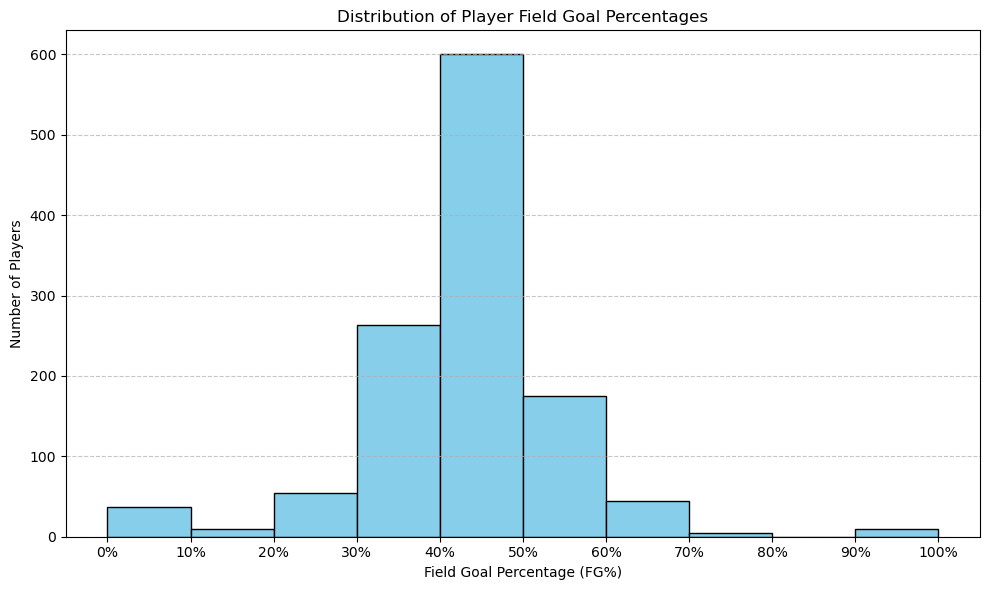

In [108]:
import matplotlib.pyplot as plt

#Calculate FG%
player_fg = df.groupby('player')['made'].agg(['count', 'sum']).rename(columns={'count': 'FGA', 'sum': 'FGM'})
player_fg['fg_percent'] = player_fg['FGM'] / player_fg['FGA']

#Plot Histogram
plt.figure(figsize=(10, 6))
plt.hist(player_fg['fg_percent'], bins=[i/10 for i in range(11)], edgecolor='black', color='skyblue')
plt.xlabel('Field Goal Percentage (FG%)')
plt.ylabel('Number of Players')
plt.title('Distribution of Player Field Goal Percentages')
plt.xticks([i/10 for i in range(11)], [f'{int(i*10)}%' for i in range(11)])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


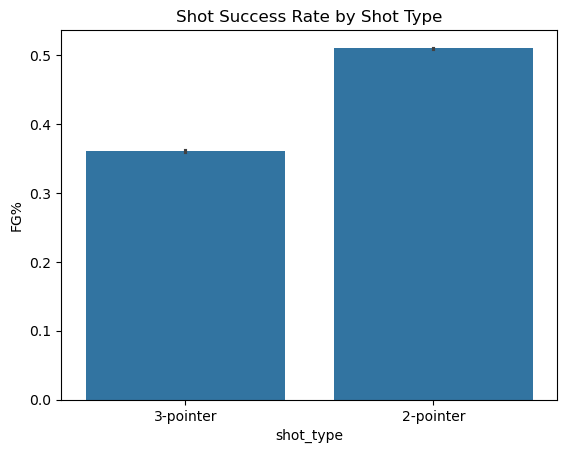

In [121]:
#Success Rate by Shot Type
sns.barplot(data=df, x='shot_type', y='made')
plt.title('Shot Success Rate by Shot Type')
plt.ylabel('FG%')
plt.show()

In [132]:
#Reading in Submission CSV
sub = pd.read_csv('submission.csv')
sub.rename(columns={'Player': 'player'}, inplace=True)

## Training the Model

In [134]:
#Assigning Season Weights
season_weights = {
    2018: 0.1,
    2019: 0.2,
    2020: 0.4,
    2021: 0.6,
    2022: 0.8,
    2023: 1.0,
    2024: 1.2
}
df['season_weight'] = df['season'].map(season_weights)

#Calculate Features
def weighted_mean(x, w):
    mean =  (x * w).sum() / w.sum()
    return mean

def calc_weighted_features(group):
    w = group['season_weight']
    return pd.Series({
        'avg_distance': weighted_mean(group['distance'], w),
        'avg_shotX': weighted_mean(group['shotX'], w),
        'avg_shotY': weighted_mean(group['shotY'], w),
        'pct_3PA': weighted_mean(group['shot_type'] == '3-pointer', w)
    })

player_features = df.groupby('player').apply(calc_weighted_features).reset_index()

#Weighted FG% Calculation
def weighted_fg(group):
    w = group['season_weight']
    return pd.Series({
        'FGM': (group['made'] * w).sum(),
        'FGA': w.sum()
    })

player_fg = df.groupby('player').apply(weighted_fg).reset_index()
player_fg['FG%'] = player_fg['FGM'] / player_fg['FGA']

#Train Model
train_data = pd.merge(player_features, player_fg[['player', 'FG%', 'FGA']], on='player')
train_data = train_data[train_data['FGA'] >= 50].dropna(subset=['FG%'])  # filter low volume players

X = train_data.drop(columns=['player', 'FG%', 'FGA'])
y = train_data['FG%']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

#Predict for submission
players_to_predict = sub['player'].tolist()
features_to_predict = player_features[player_features['player'].isin(players_to_predict)]

# Merge predicted FG% into the sub dataframe
X_pred = features_to_predict.drop(columns=['player'])
features_to_predict['Predicted FG%'] = model.predict(X_pred)

# Merge predictions into sub
sub = sub.drop(columns=['FG%'], errors='ignore')  # drop FG% if it exists
sub = sub.merge(features_to_predict[['player', 'Predicted FG%']], on='player', how='left')

/var/folders/cd/1g2vg20s2qldygvwt3kd9jhc0000gn/T/ipykernel_46149/3169690064.py:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  player_features = df.groupby('player').apply(calc_weighted_features).reset_index()
/var/folders/cd/1g2vg20s2qldygvwt3kd9jhc0000gn/T/ipykernel_46149/3169690064.py:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  player_fg = df.groupby('player').apply(weighted_fg).reset_index()
/va

In [140]:
sub.rename(columns={'Predicted FG%': 'FG%'}, inplace=True)
sub = sub[['player', 'FG%', 'FGA']]

print(sub.head())

    player       FG%  FGA
0  2000000  0.608423   80
1  2000011  0.496467  660
2  2000016  0.436044  230
3  2000019  0.457068   60
4  2000029  0.465071   40


In [92]:
sub.to_csv('updated_submission.csv')

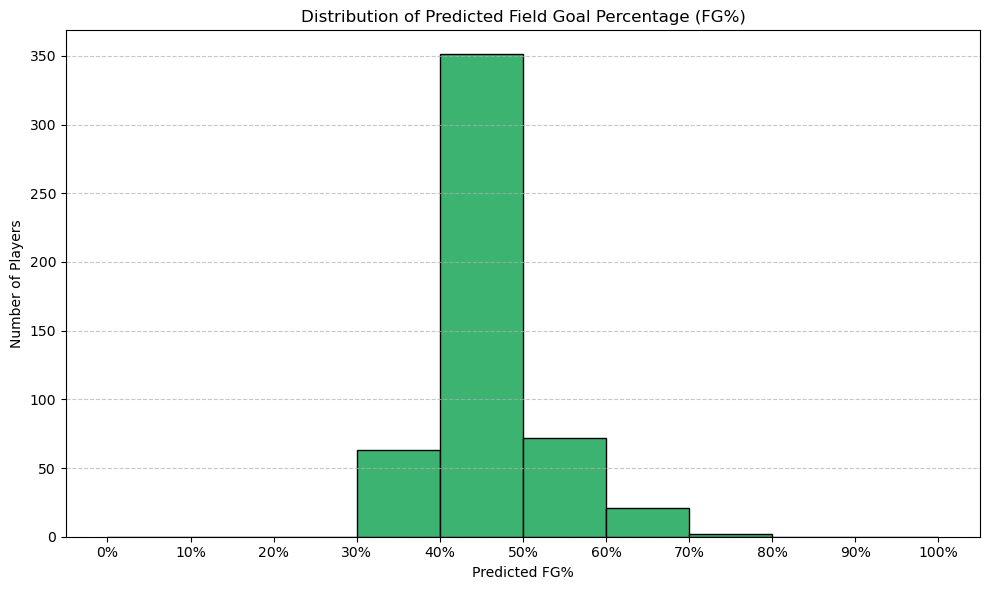

In [142]:
plt.figure(figsize=(10, 6))
plt.hist(sub['FG%'], bins=[i/10 for i in range(11)], edgecolor='black', color='mediumseagreen')
plt.xlabel('Predicted FG%')
plt.ylabel('Number of Players')
plt.title('Distribution of Predicted Field Goal Percentage (FG%)')
plt.xticks([i/10 for i in range(11)], [f'{int(i*10)}%' for i in range(11)])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [146]:
#Players in Each Bin
bins = [i/10 for i in range(11)]
labels = [f"{int(i*100)}–{int((i+0.1)*100)}%" for i in bins[:-1]]

sub['FG_bin'] = pd.cut(sub['FG%'], bins=bins, labels=labels, include_lowest=True, right=False)

# Count players in each bin
bin_counts = sub['FG_bin'].value_counts().sort_index()

bin_counts

/var/folders/cd/1g2vg20s2qldygvwt3kd9jhc0000gn/T/ipykernel_46149/4282738659.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['FG_bin'] = pd.cut(sub['FG%'], bins=bins, labels=labels, include_lowest=True, right=False)


FG_bin
0–10%        0
10–20%       0
20–30%       0
30–40%      63
40–50%     351
50–60%      72
60–70%      21
70–80%       2
80–90%       0
90–100%      0
Name: count, dtype: int64